In [1]:
from collections import defaultdict
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
# gensim
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
# logging for gensim (set to INFO)
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from mongo_client import mongo_client

/usr/local/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
db = mongo_client.get_database('historical_events')
collection = db.get_collection('event_descriptions')

In [3]:
stop_words = list(ENGLISH_STOP_WORDS) + [
    'abc', 'ampndash', 'ampamp', 'amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref',
    'http', 'href', 'html', 'htm', 'www', 'com', 'ref', 'quotpocket', 'cbf', 'quot'
]
count_vectorizer = CountVectorizer(ngram_range=(2,2), min_df=0.001, max_df=0.9,
                                   stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b")
docs = [doc['description'].split('{{')[0] for doc in collection.find()]
count_vectorizer.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.001,
        ngram_range=(2, 2), preprocessor=None,
        stop_words=['fill', 'namely', 'noone', 'de', 'thin', 'why', 'otherwise', 'everything', 'eight', 'however', 'he', 'thence', 'sometime', 'your', 'us', 'during', 'becomes', 'sixty', 'she', 'therefore', 'this', 'see', 'few', 'never', 'amoungst', 'than', 'to', 'here', 'least', 'off', 'much', 'seeming', '...quotthe', 'ampref', 'http', 'href', 'html', 'htm', 'www', 'com', 'ref', 'quotpocket', 'cbf', 'quot'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [4]:
count_vectorizer.get_feature_names()

['abraham lincoln',
 'academy awards',
 'act law',
 'admitted state',
 'adolf hitler',
 'african american',
 'air force',
 'airlines flight',
 'american civil',
 'american indian',
 'american revolution',
 'american revolutionary',
 'american troops',
 'american war',
 'angeles california',
 'anglo dutch',
 'arab democratic',
 'assassination attempt',
 'atlantic ocean',
 'austria hungary',
 'best picture',
 'bomb explodes',
 'boston massachusetts',
 'british army',
 'british east',
 'british empire',
 'british forces',
 'british government',
 'british parliament',
 'british prime',
 'british troops',
 'carlist war',
 'catholic church',
 'ceremony held',
 'charles gaulle',
 'charles ii',
 'civil rights',
 'civil war',
 'club founded',
 'cold war',
 'communist party',
 'company founded',
 'court united',
 'crashes near',
 'days later',
 'declares independence',
 'declares war',
 'democratic party',
 'democratic republic',
 'diplomatic relations',
 'disarmament crisis',
 'dominican republ

In [5]:
counts = count_vectorizer.transform(docs).transpose()
counts.shape

(271, 23911)

In [6]:
corpus = matutils.Sparse2Corpus(counts)

In [7]:
id2word = {id: word for word, id in count_vectorizer.vocabulary_.items()}

In [8]:
num_topics = 64
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, minimum_probability=0.01, id2word=id2word, passes=20)

In [9]:
lda.show_topics()

[(58,
  '0.403*"northern ireland" + 0.358*"house representatives" + 0.202*"british prime" + 0.000*"republic congo" + 0.000*"revolutionary war" + 0.000*"resigns prime" + 0.000*"republican army" + 0.000*"republic sadr" + 0.000*"richard nixon" + 0.000*"republic china"'),
 (3,
  '0.338*"abraham lincoln" + 0.320*"states congress" + 0.311*"united states" + 0.000*"republic china" + 0.000*"resigns prime" + 0.000*"republican army" + 0.000*"republic sadr" + 0.000*"republic congo" + 0.000*"revolutionary war" + 0.000*"red army"'),
 (41,
  '0.251*"admitted state" + 0.170*"war independence" + 0.149*"lyndon johnson" + 0.135*"president lyndon" + 0.135*"eurovision song" + 0.135*"song contest" + 0.000*"revolutionary war" + 0.000*"puerto rico" + 0.000*"republican army" + 0.000*"rhode island"'),
 (14,
  '0.310*"national assembly" + 0.300*"puerto rico" + 0.281*"club founded" + 0.072*"mexican revolution" + 0.000*"republic china" + 0.000*"revolutionary war" + 0.000*"resigns prime" + 0.000*"republican army" +

In [10]:
lda.log_perplexity(corpus)

-5.249720182190042

In [11]:
lda.get_document_topics(corpus[-120])

[(28, 0.5078125)]

In [12]:
corpus[-120]

[(146, 1)]

In [14]:
def get_doc_topics(text):
    doc = text.split('{{')[0]
    counts = count_vectorizer.transform([doc]).transpose()
    return lda.get_document_topics(matutils.Sparse2Corpus(counts)[0])

# get_doc_topics('This is some text')

In [15]:
topics_by_year ={}
for year in range(1600, 2012):
    year_topics = defaultdict(float)
    total_score = 0.0
    for mdoc in collection.find({'year': year}):
        for top, score in get_doc_topics(mdoc['description']):
            score = score ** 2
            year_topics[top] += score
            total_score += score
    for top, score in year_topics.items():
        year_topics[top] = score / total_score
    topics_by_year[year] = year_topics

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


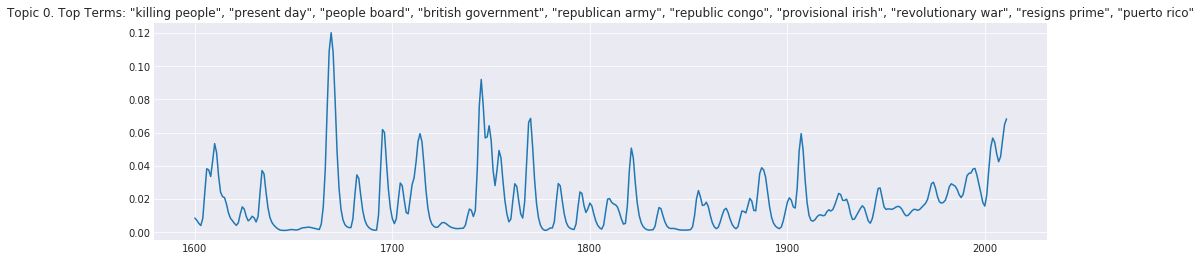

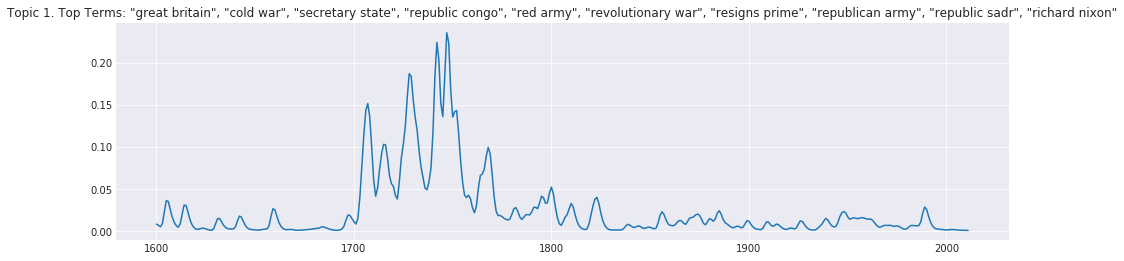

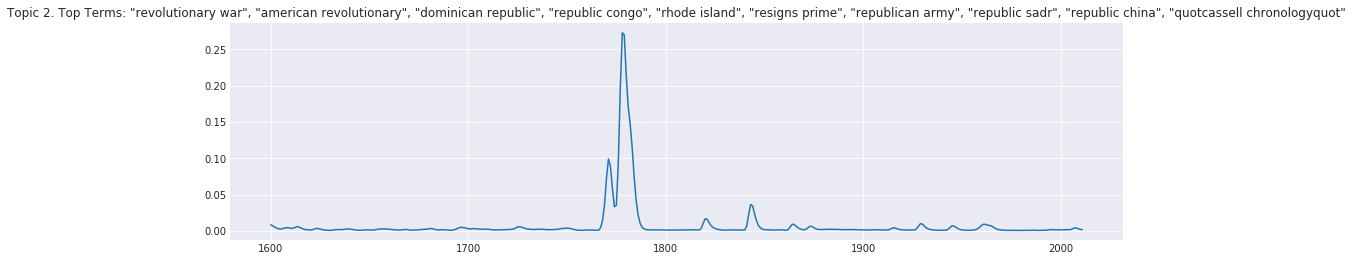

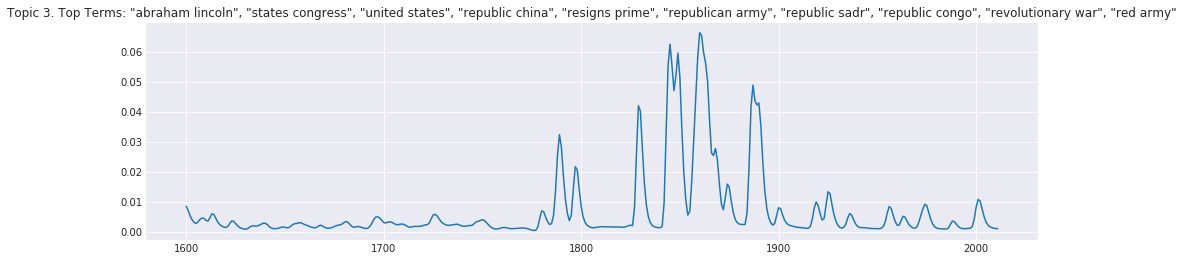

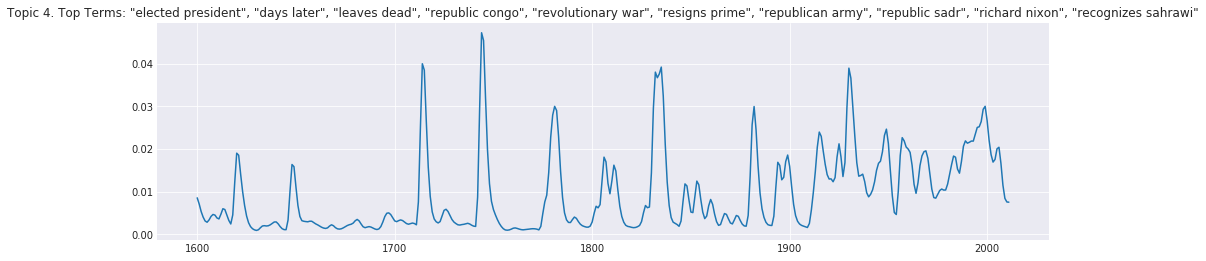

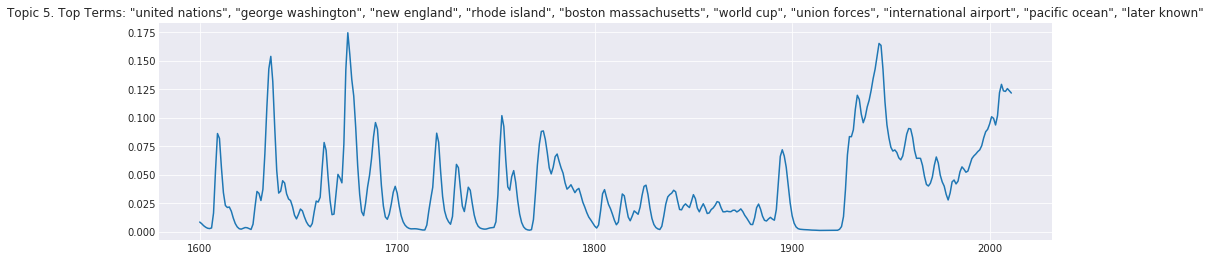

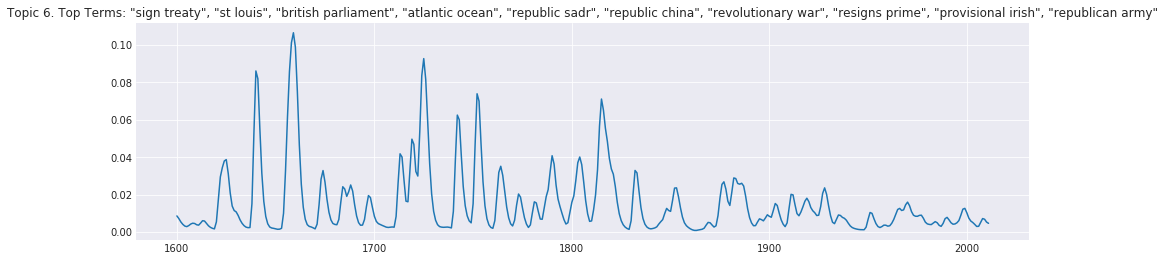

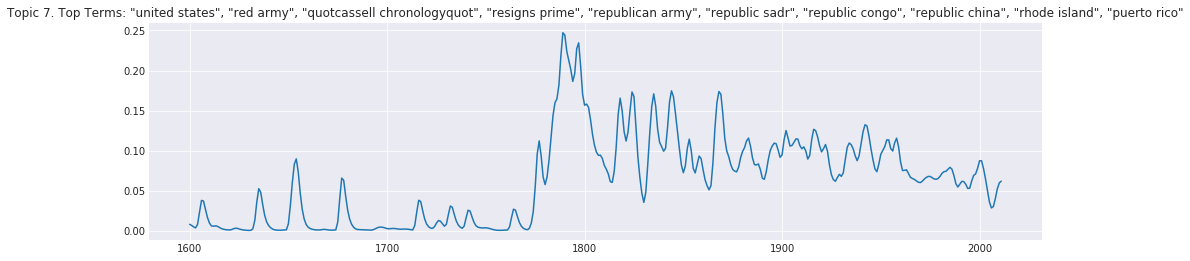

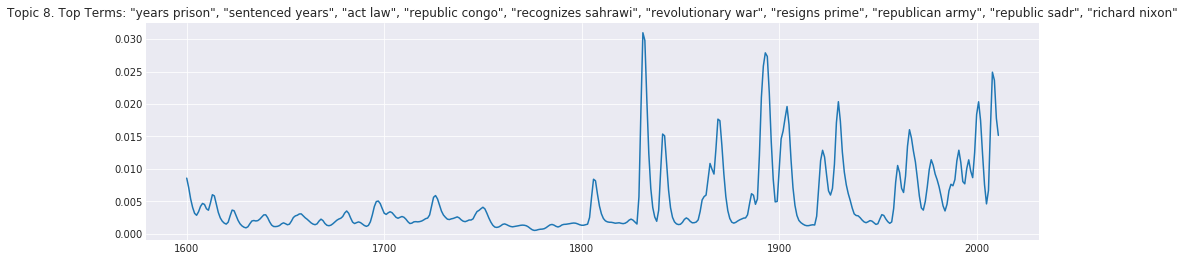

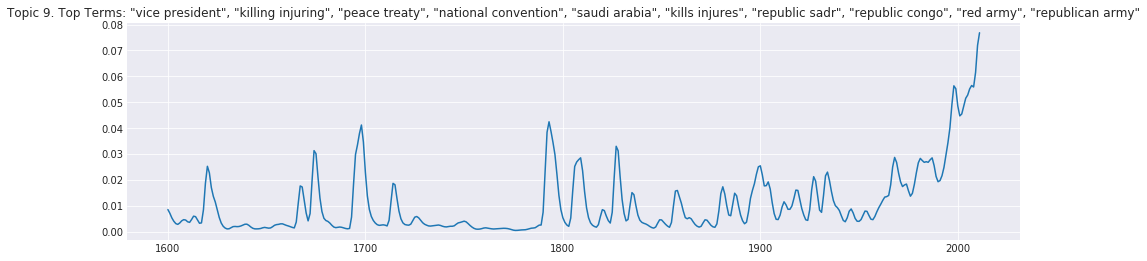

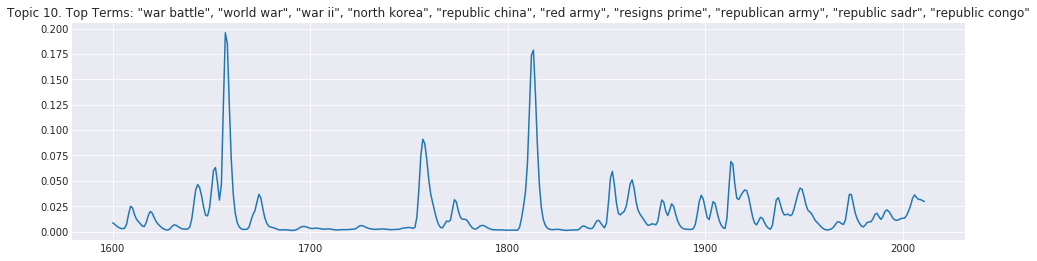

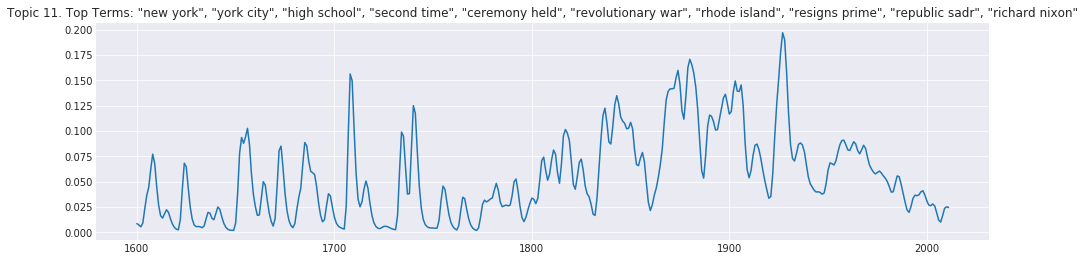

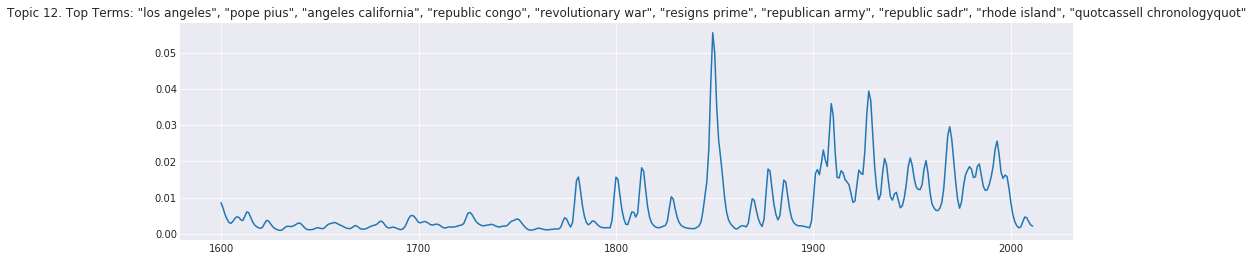

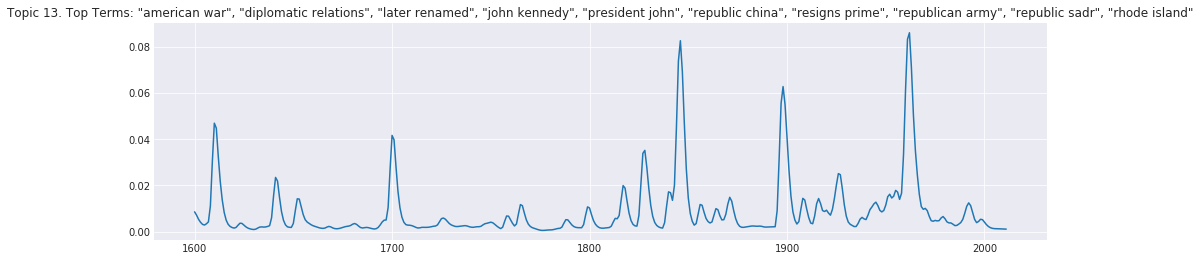

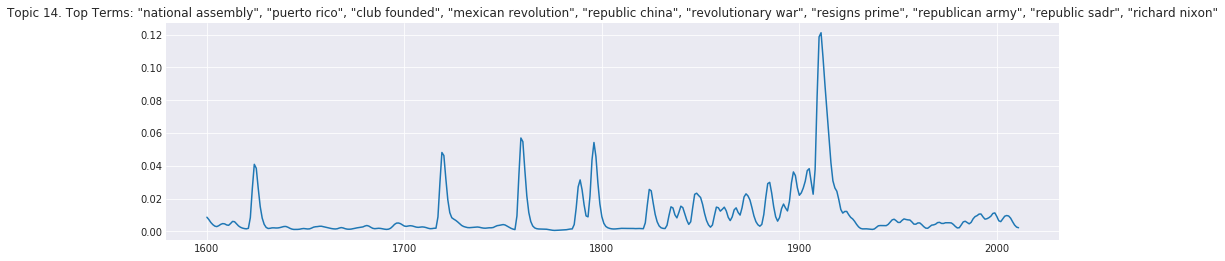

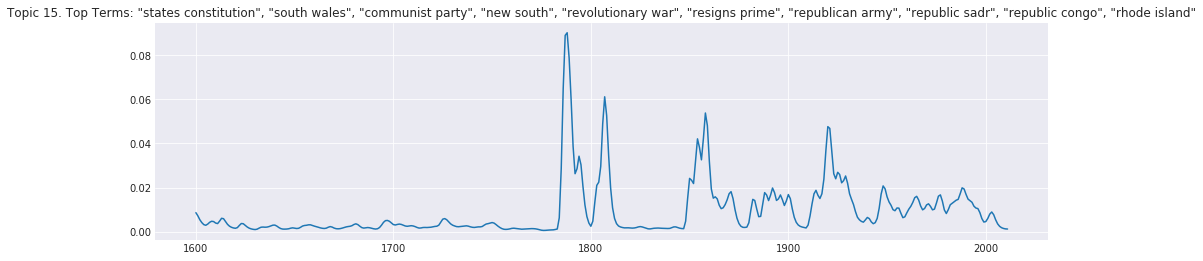

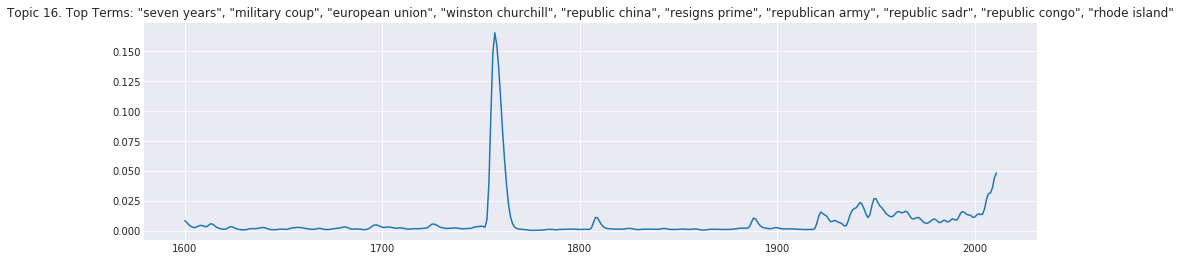

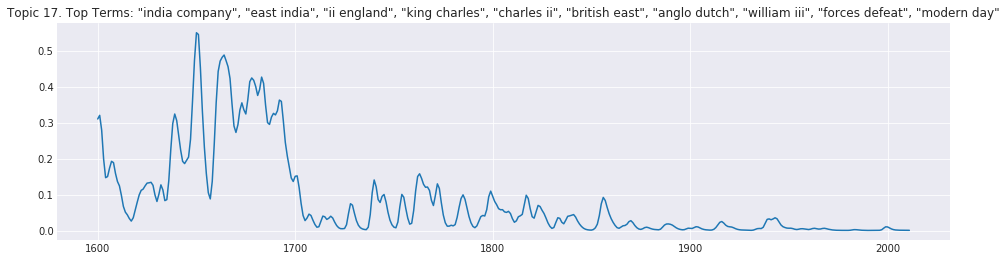

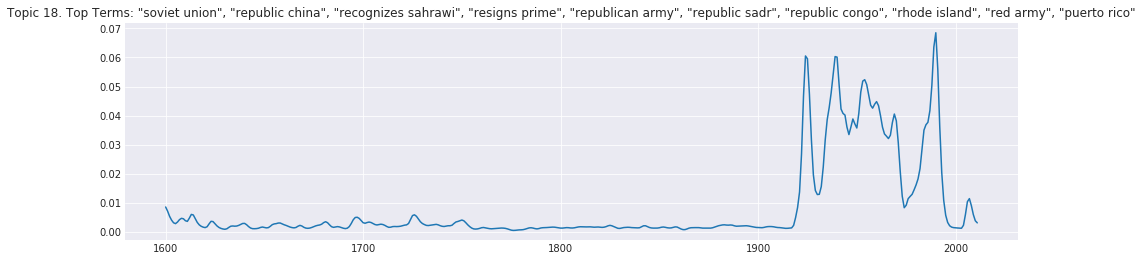

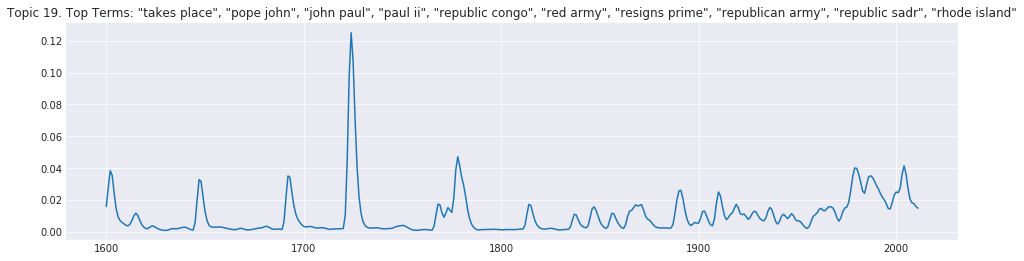

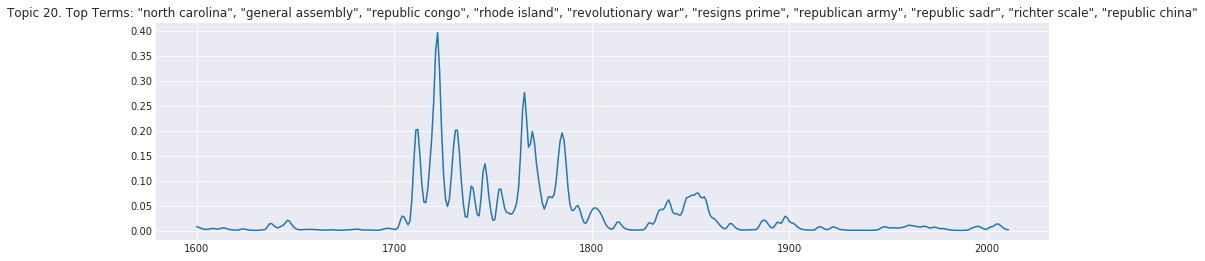

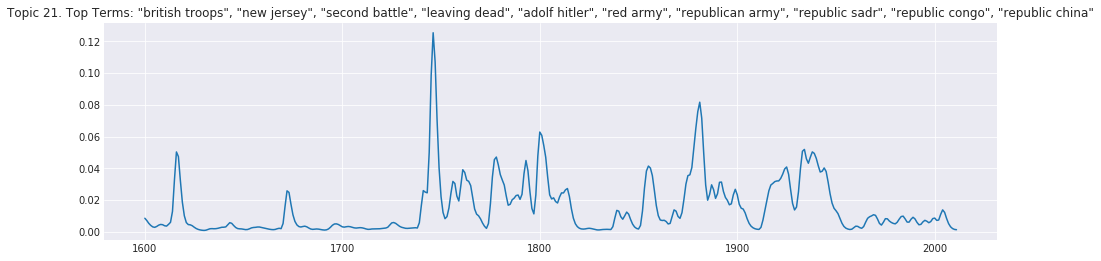

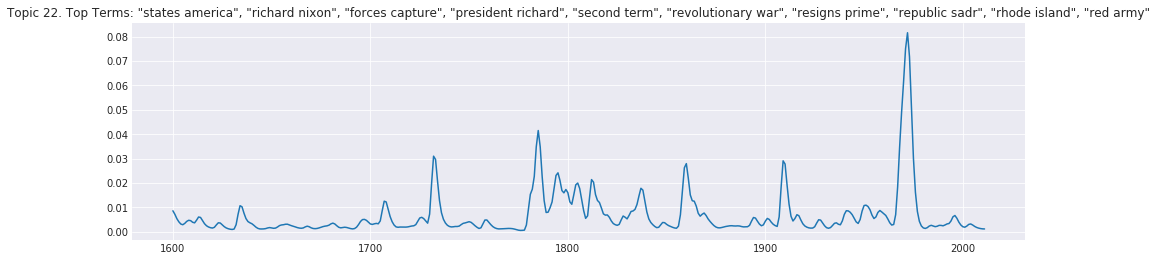

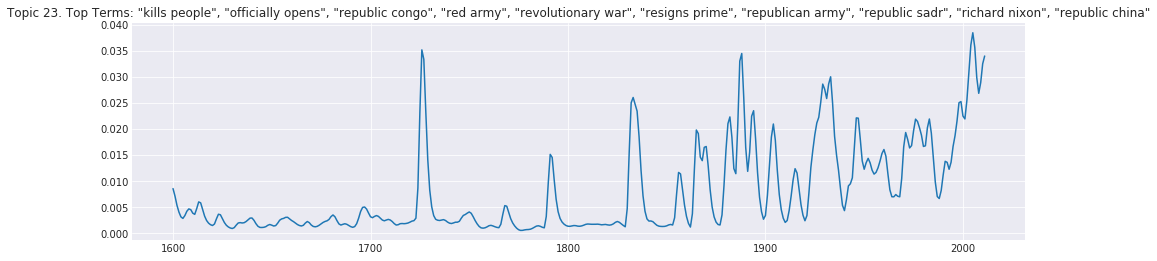

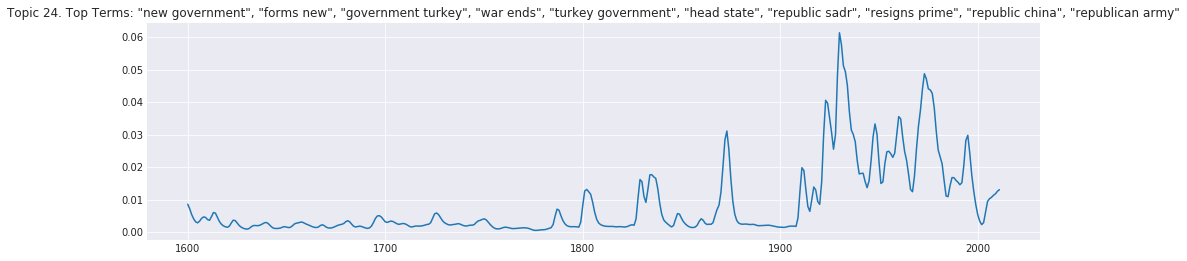

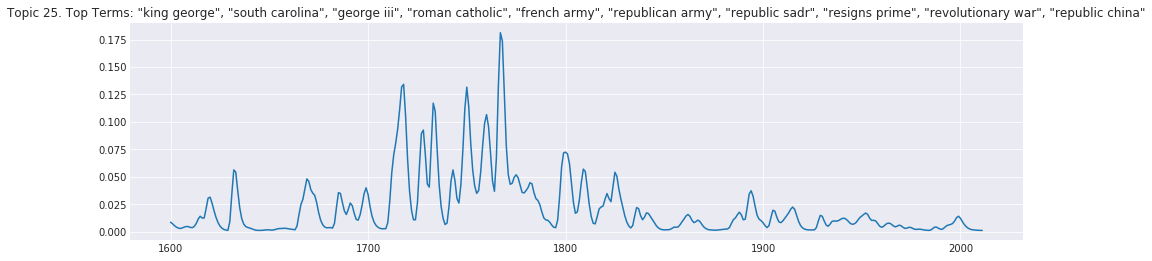

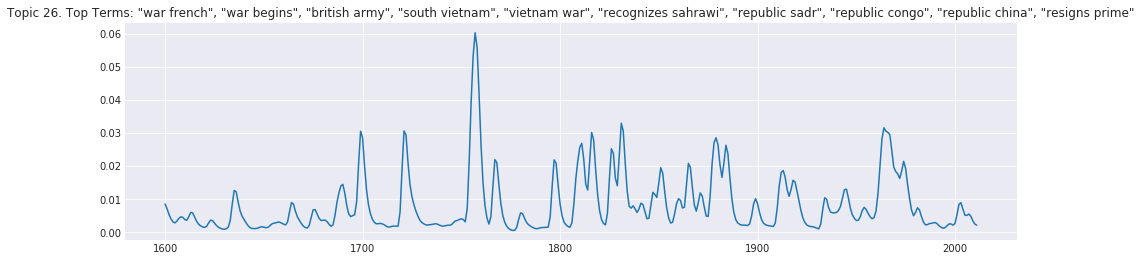

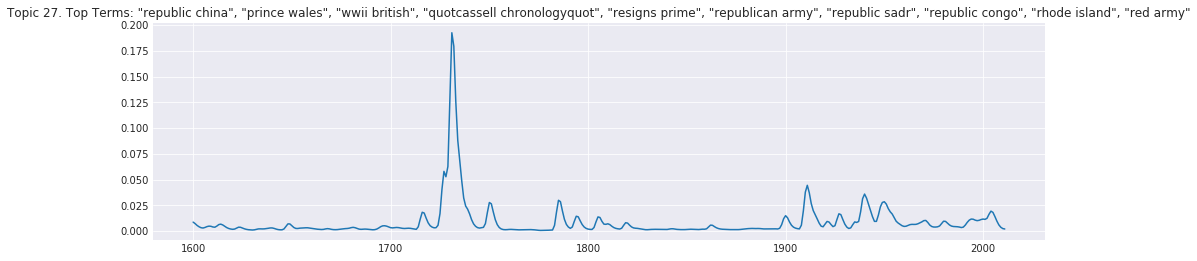

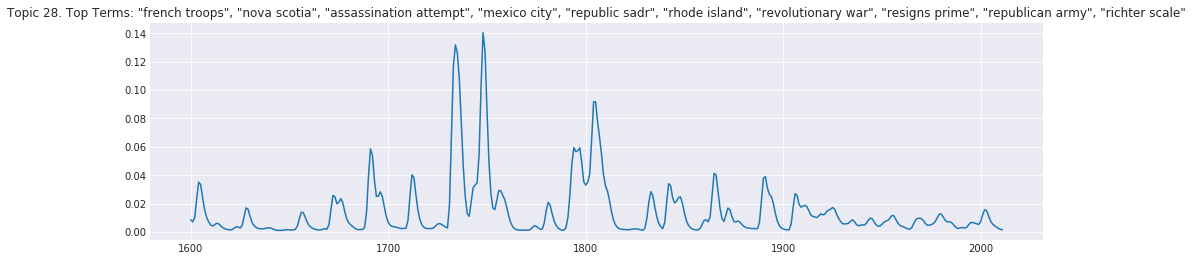

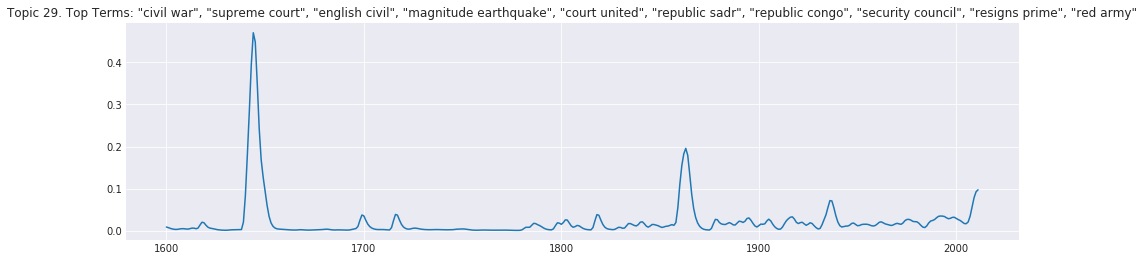

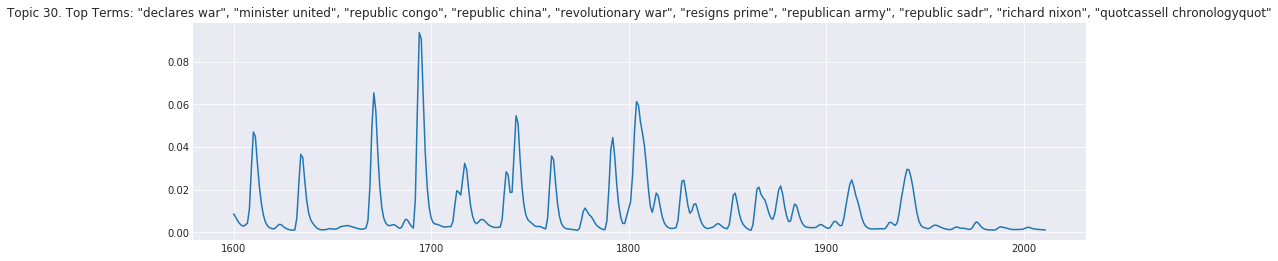

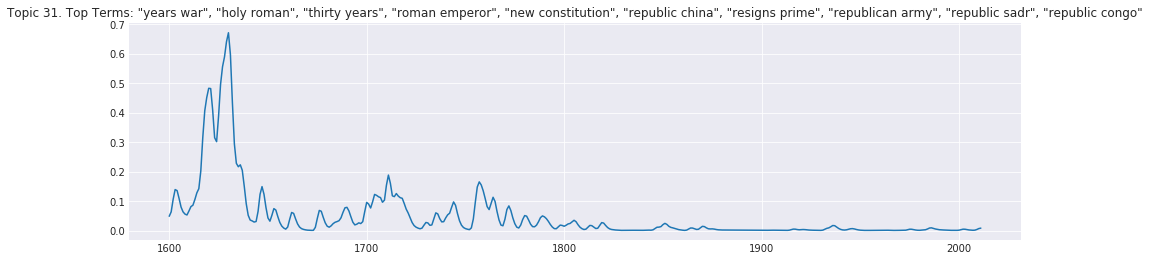

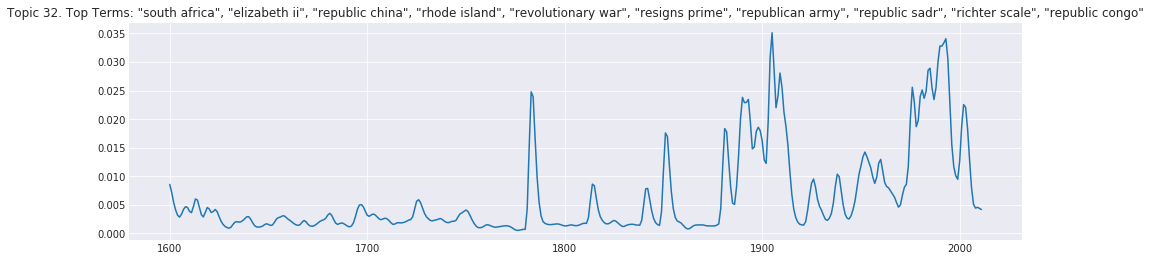

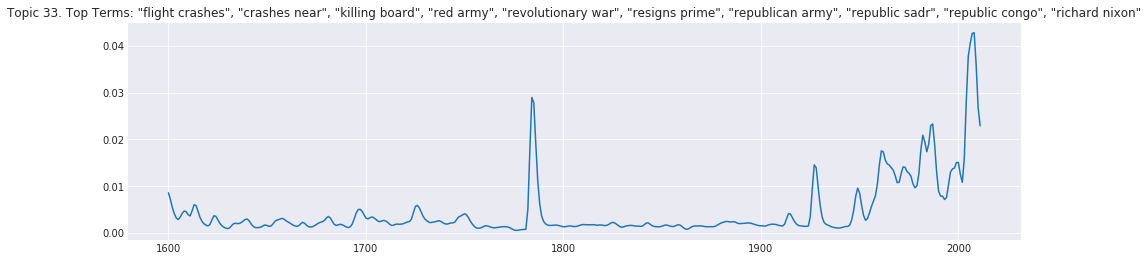

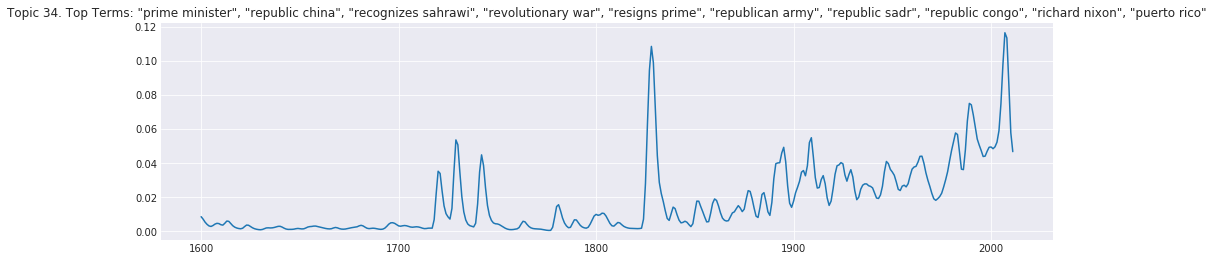

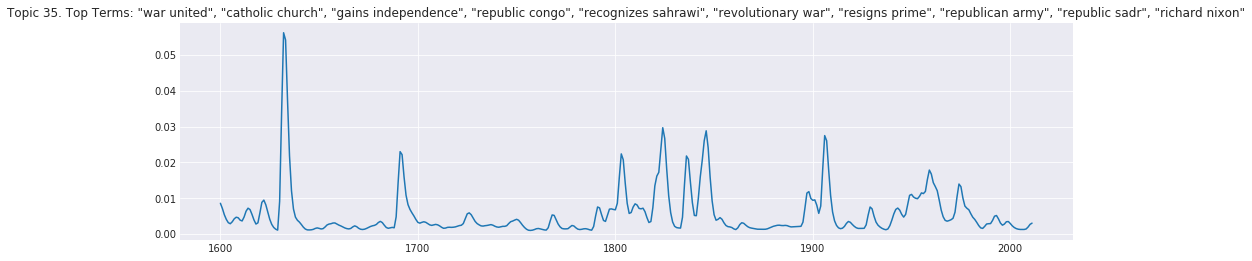

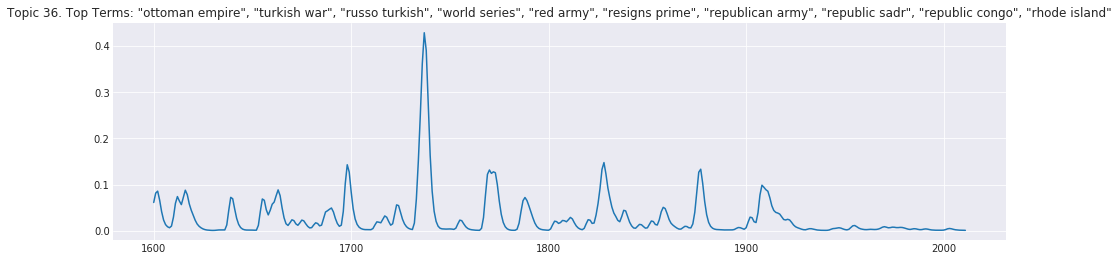

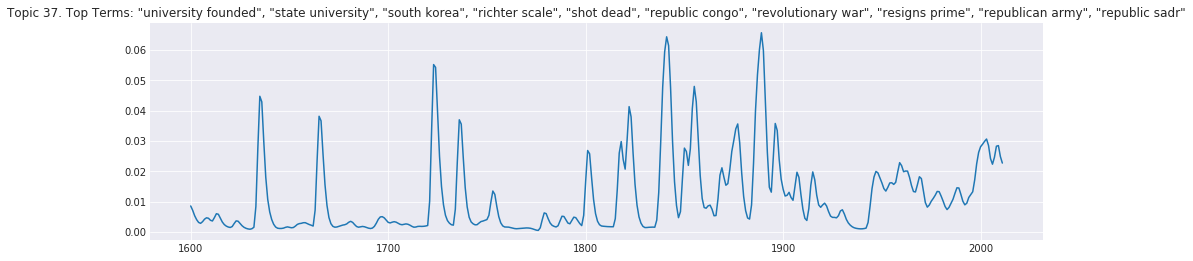

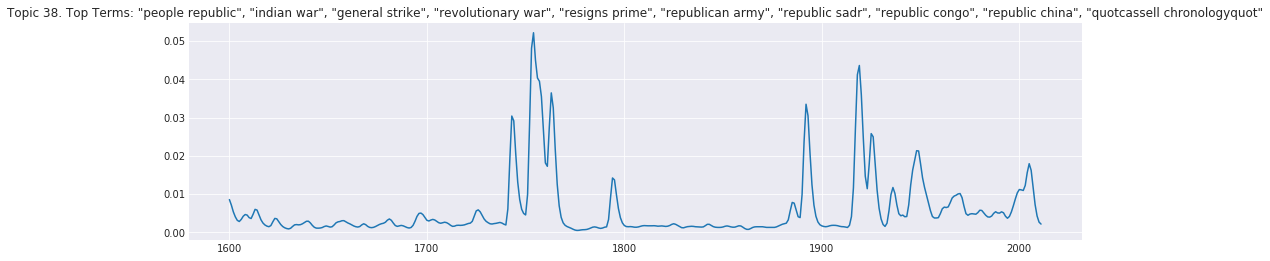

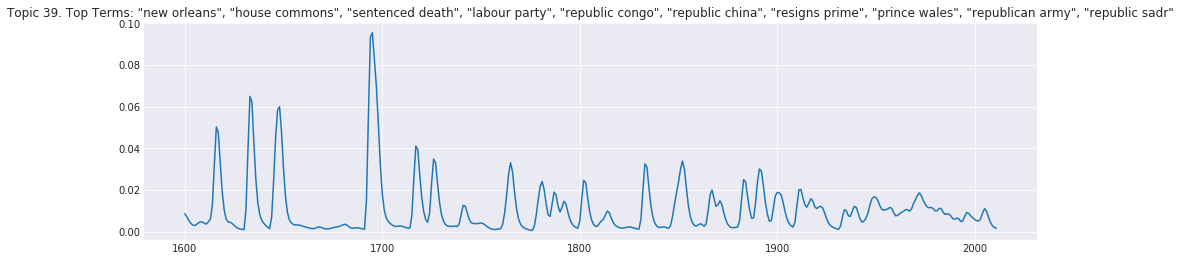

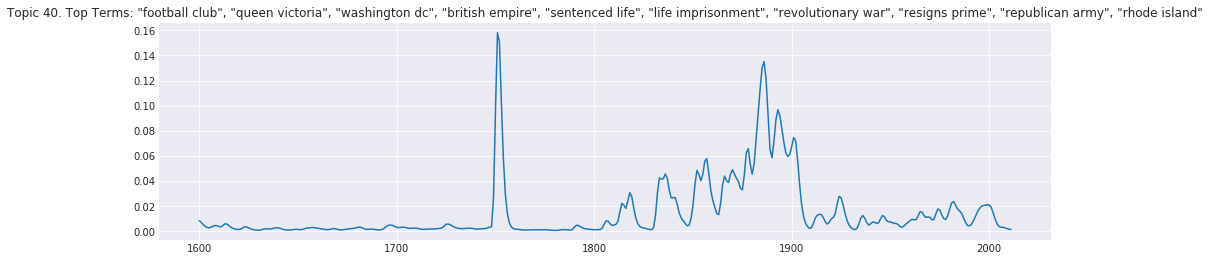

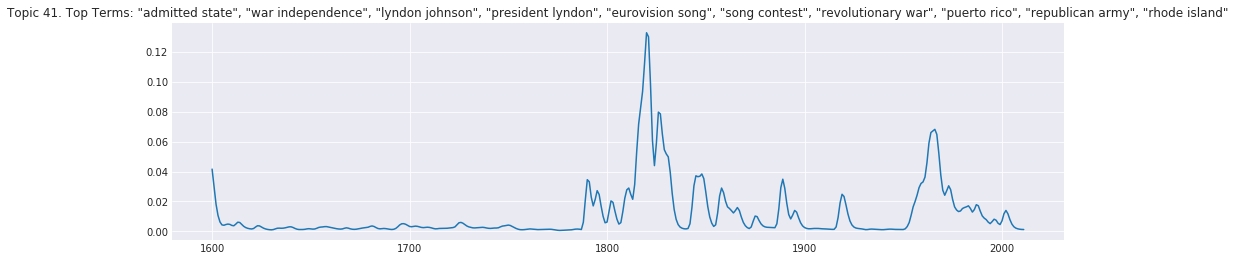

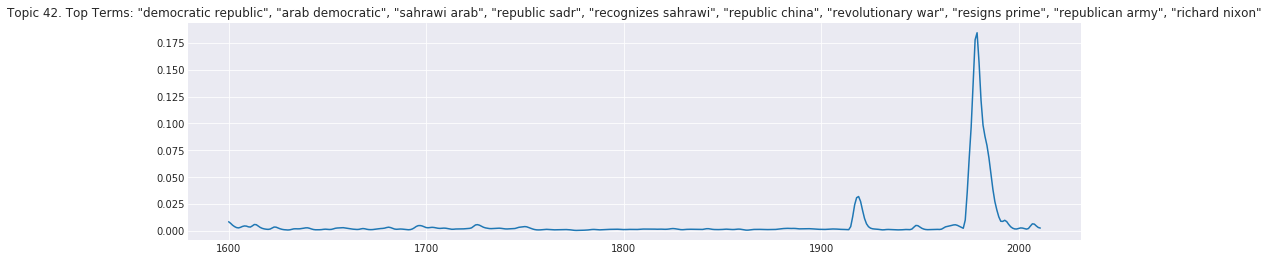

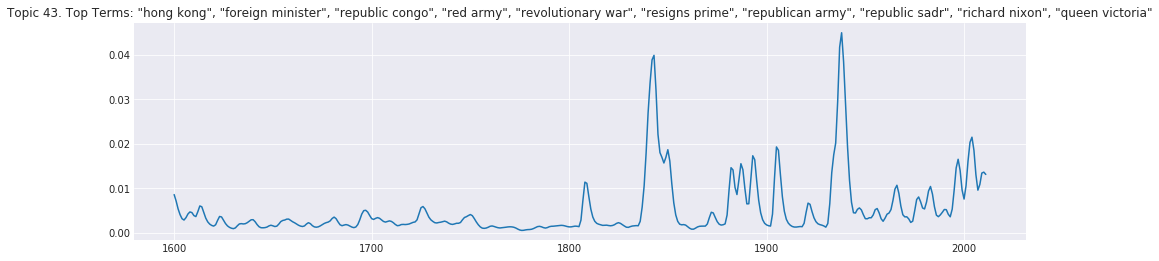

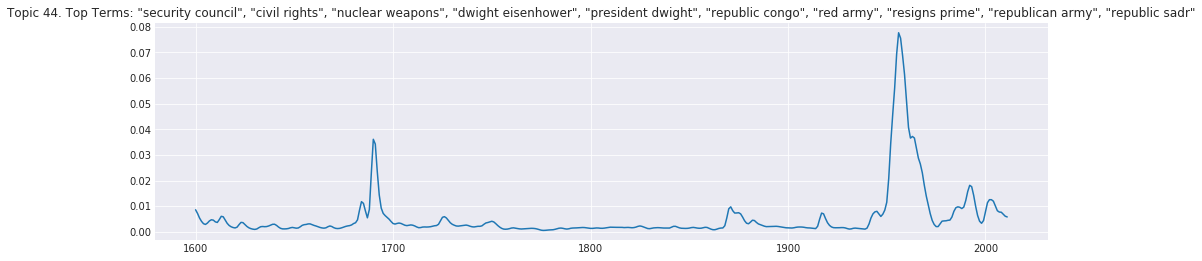

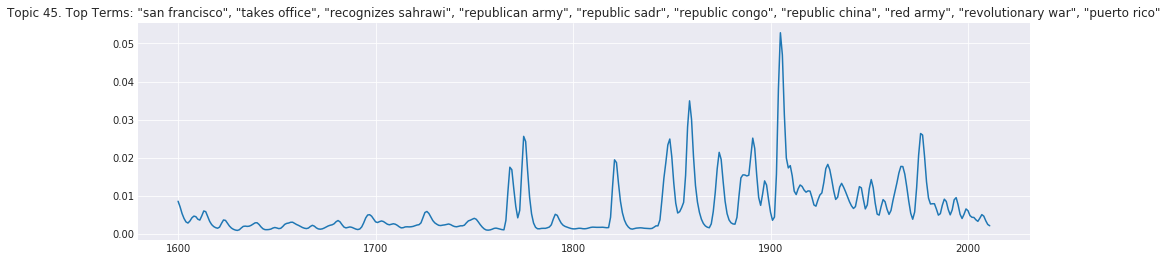

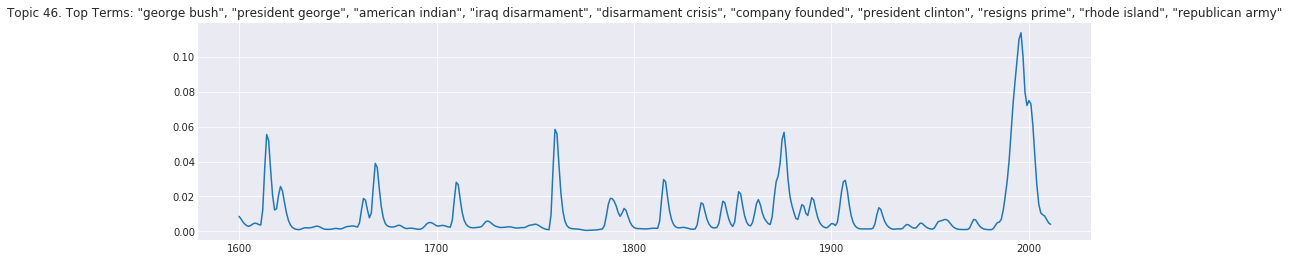

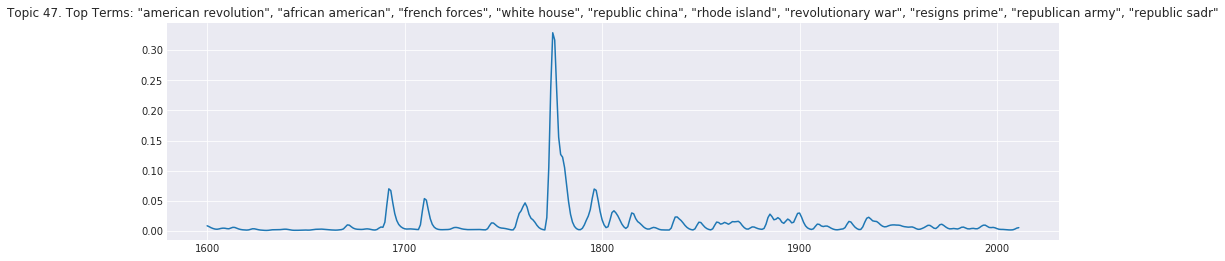

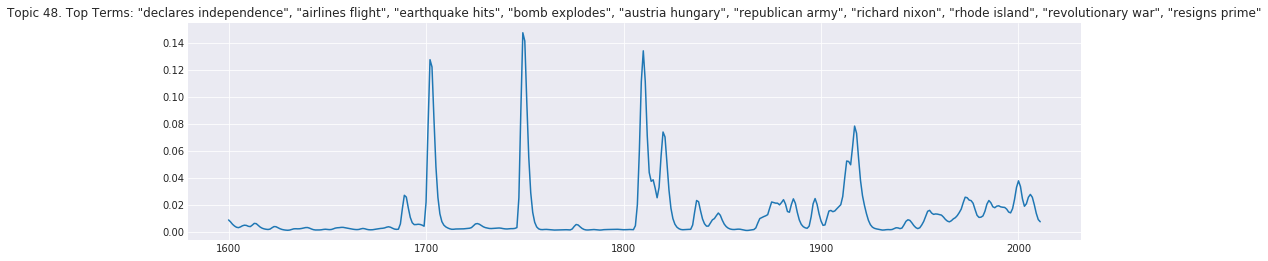

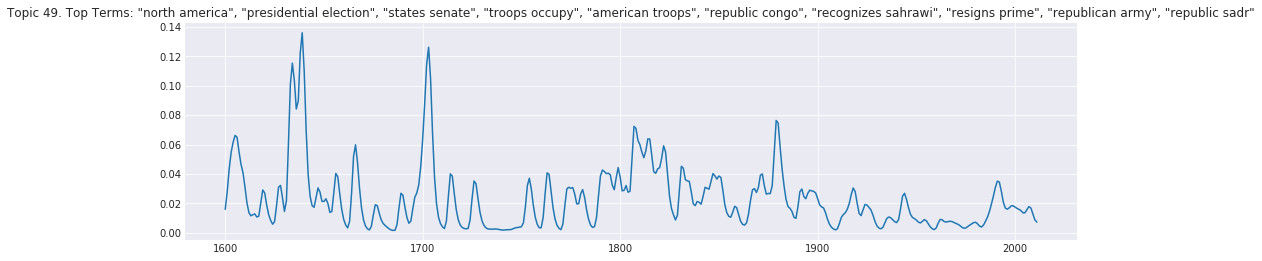

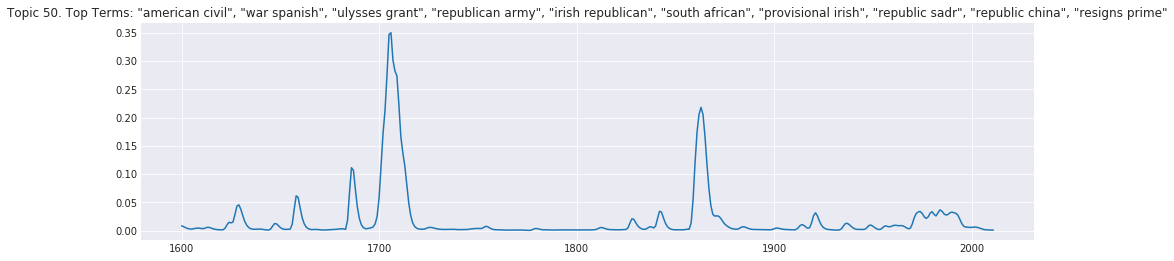

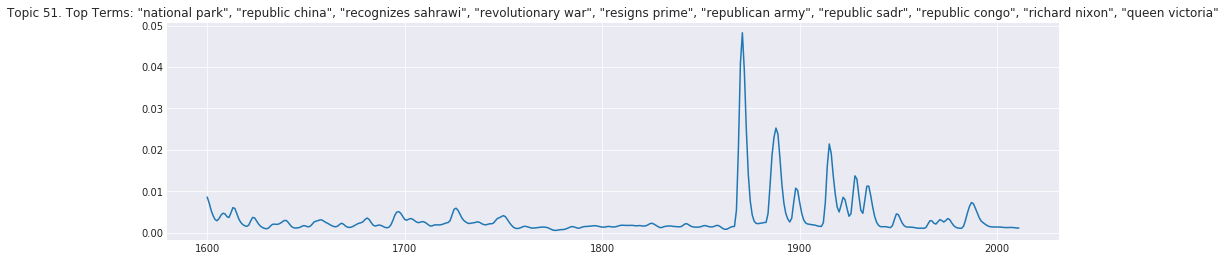

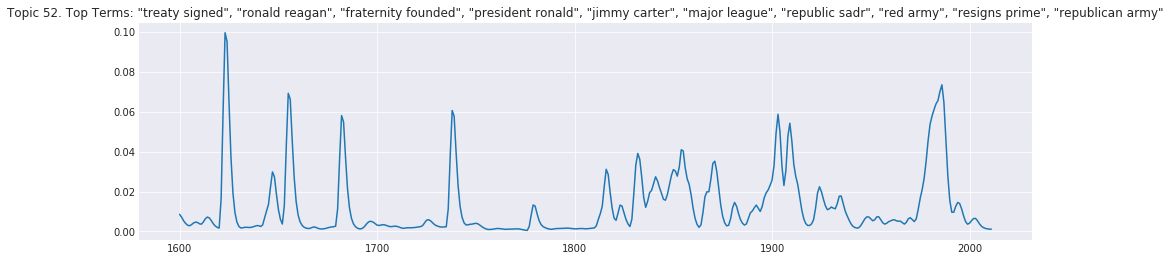

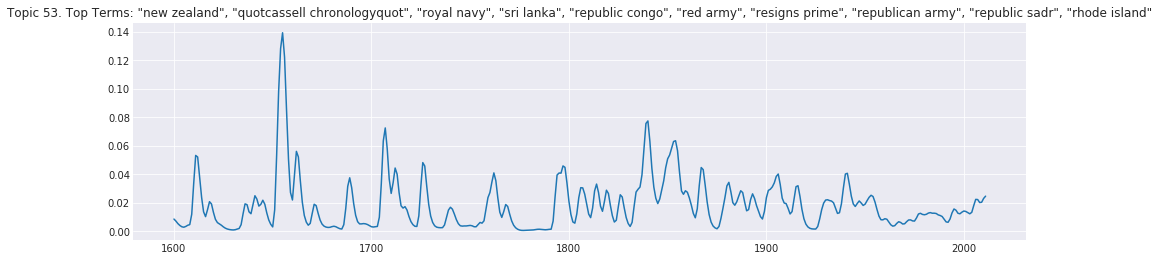

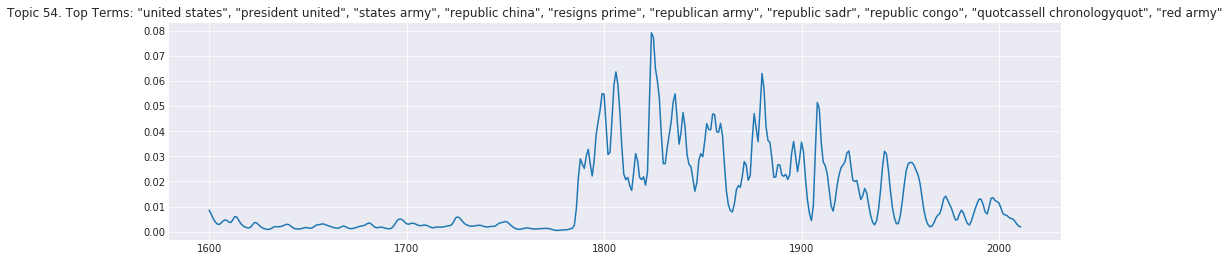

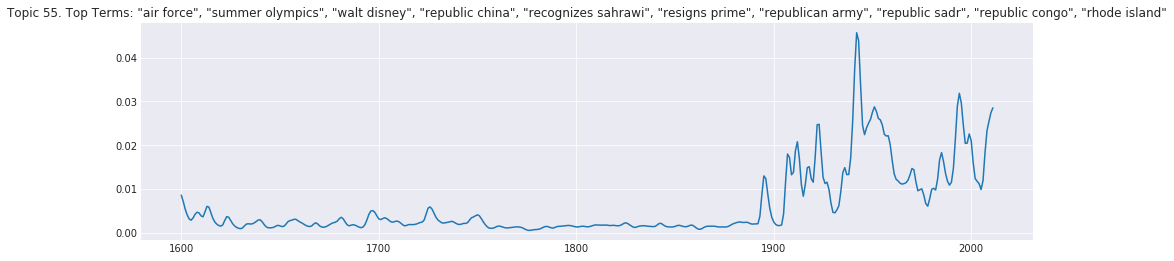

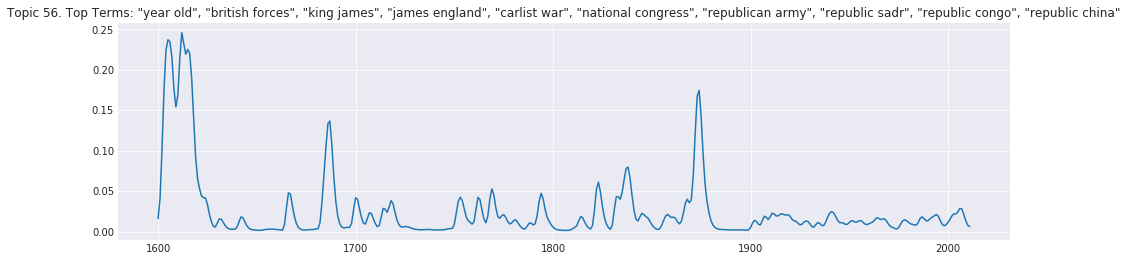

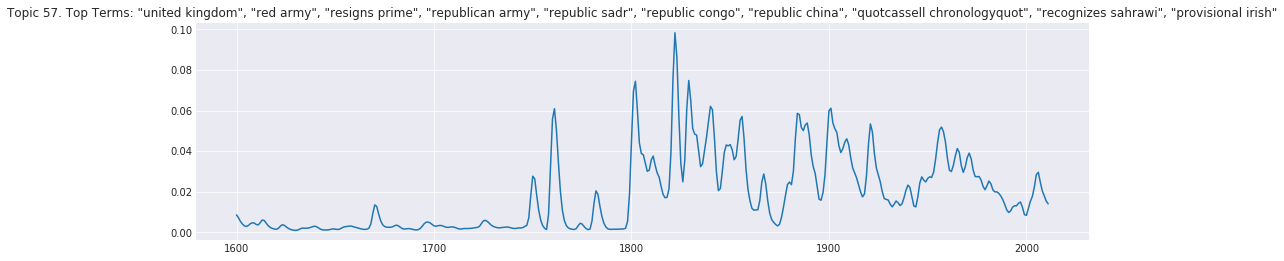

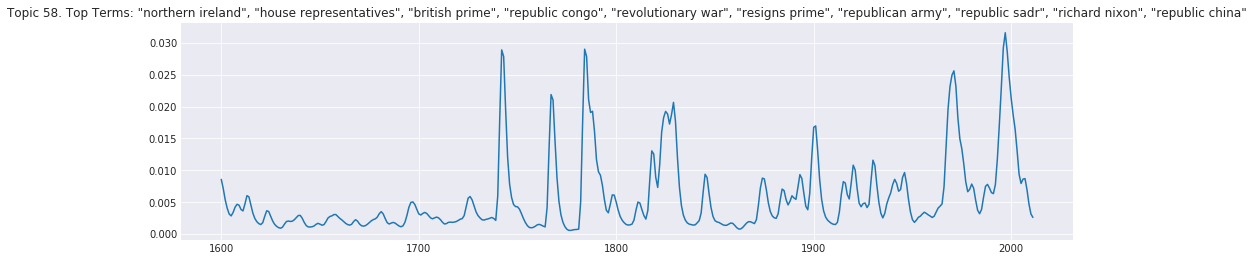

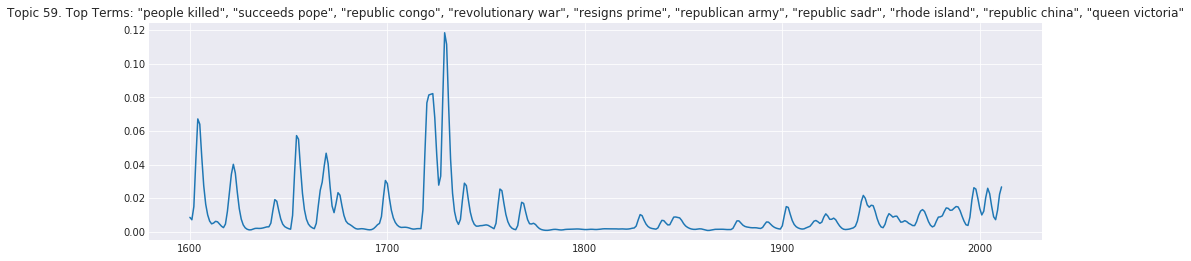

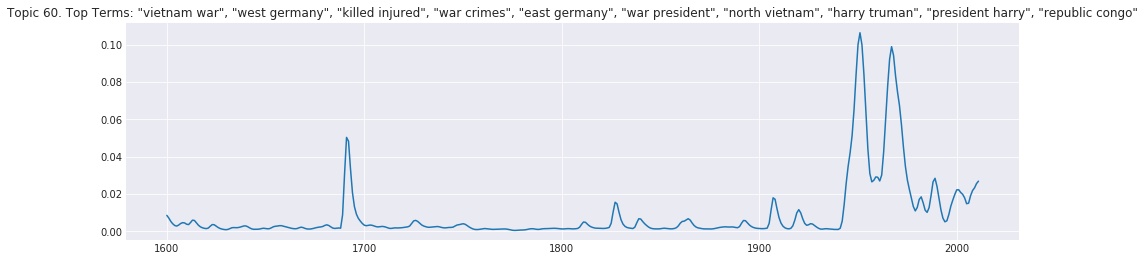

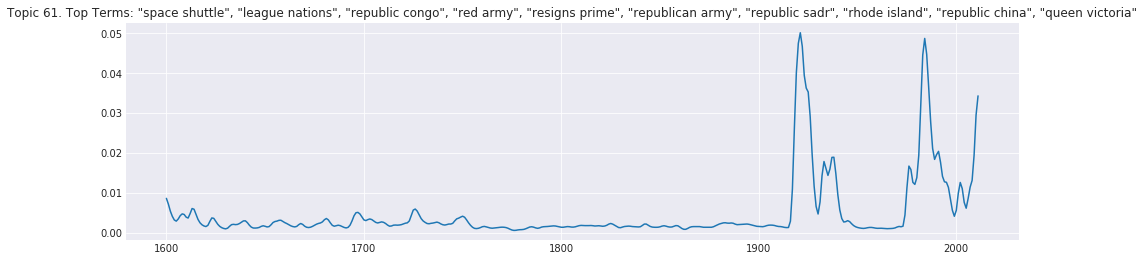

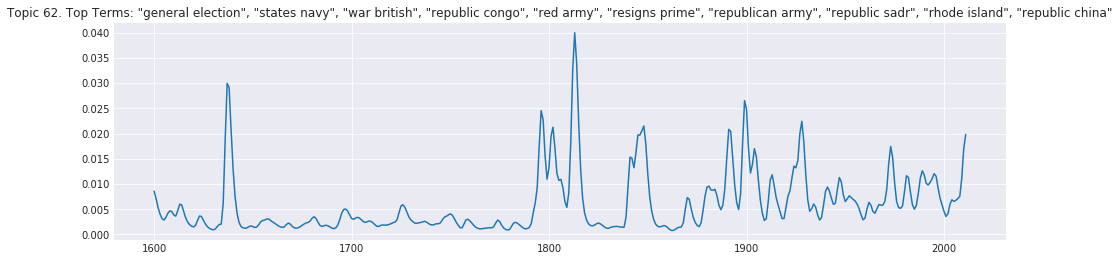

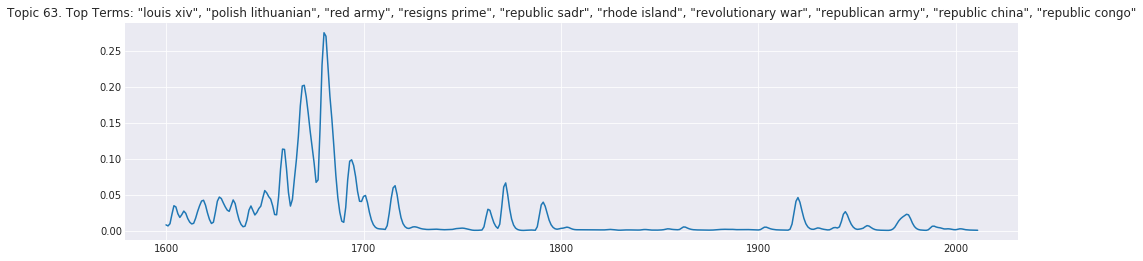

In [16]:
for top in range(num_topics):
    terms = [id2word[id] for id, _ in lda.get_topic_terms(top)]
    x = list(topics_by_year.keys())
    y = [tops[top] for tops in topics_by_year.values()]
    for _ in range(3):
        y[0] = (y[0] + y[1]) / 2
        for i in range(1, len(y) - 1):
            y[i] = (y[i - 1] + y[i] + y[i + 1]) / 3
        y[-1] = (y[-2] + y[-1]) / 2
#     spl = UnivariateSpline(x, y)
#     spl.set_smoothing_factor(0.3)
    plt.figure(figsize=(16,4))
    plt.title('Topic {}. Top Terms: "{}"'.format(top, '", "'.join(terms)))
#     plt.plot(x, spl(x));
    plt.plot(x, y);

In [ ]:
# def string_to_vec(string):
#     vec = [0] * num_topics
#     for top, score in get_doc_topics(string):
#         vec[top] = score
#     return vec

# X = []
# y = []
# for mdoc in collection.find():
#     year = mdoc['year']
#     vec = string_to_vec(mdoc['description'])
#     X.append(vec)
#     y.append(year)
    
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# nn = MLPRegressor(hidden_layer_sizes=(num_topics * 2,))
# nn.fit(X_train, y_train)
# nn.score(X_test, y_test)

In [ ]:
# nn.predict([string_to_vec('George Bush went to Iraq.')])

In [17]:
pyLDAvis.gensim.prepare(lda, corpus, corpora.Dictionary.from_corpus(corpus, id2word=id2word))

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.466160 -0.006837       1        1  5.600585
5     -0.017791 -0.016189       2        1  4.397779
11    -0.010957 -0.158478       3        1  4.329210
29    -0.012262 -0.135339       4        1  2.934626
50    -0.014576 -0.092394       5        1  2.435169
17    -0.014595 -0.083413       6        1  2.323616
34    -0.013539 -0.120824       7        1  2.316239
60    -0.023602  0.035001       8        1  2.204270
10    -0.014395 -0.100713       9        1  2.143758
57    -0.014963 -0.096699      10        1  2.037586
42    -0.019787 -0.011706      11        1  2.022745
31    -0.012254 -0.135000      12        1  1.954365
54     0.432618  0.013717      13        1  1.947564
24    -0.021704  0.017960      14        1  1.827871
18    -0.019074 -0.030494      15        1  1.755264
0     -0.017005 -0.057097      16        1  1.656997
49    -0.016324 -0.066367      17        1  1.640035
56    -0.015867 -0.072019      18        1  1.621746
9     -0.019439 -0.015254      19        1  1.559396
46    -0.019314 -0.015382      20        1  1.519943
44    -0.022943  0.033158      21        1  1.513366
20    -0.013664 -0.116553      22        1  1.492048
1     -0.015308 -0.086972      23        1  1.485626
22    -0.021043  0.006724      24        1  1.480522
41    -0.022560  0.029856      25        1  1.430939
19    -0.019979 -0.010878      26        1  1.426986
47    -0.015377 -0.083925      27        1  1.426865
48    -0.020711  0.001851      28        1  1.419966
21    -0.019179 -0.021176      29        1  1.412544
53    -0.018141 -0.038999      30        1  1.359981
...         ...       ...     ...      ...       ...
16    -0.019258 -0.021925      35        1  1.296849
15    -0.021006  0.004471      36        1  1.285140
36    -0.017733 -0.045443      37        1  1.281433
37    -0.021365  0.013079      38        1  1.279567
12    -0.023642  0.038968      39        1  1.267111
26    -0.025370  0.046816      40        1  1.208615
27    -0.024814  0.053861      41        1  1.195538
4     -0.021988  0.016395      42        1  1.189186
38    -0.023067  0.031294      43        1  1.165149
55    -0.026611  0.075643      44        1  1.121379
33    -0.025977  0.068239      45        1  1.105180
32    -0.024235  0.044742      46        1  1.079122
39    -0.023950  0.044879      47        1  1.072953
58    -0.025049  0.057020      48        1  1.071445
6     -0.021825  0.016080      49        1  1.057780
62    -0.025745  0.065521      50        1  1.044014
63    -0.021425  0.010293      51        1  1.043641
23    -0.024160  0.043699      52        1  1.041799
28    -0.022217  0.021569      53        1  1.013478
3      0.388154  0.045377      54        1  1.011201
30    -0.024040  0.042194      55        1  1.001333
35    -0.026821  0.078134      56        1  0.973487
14    -0.025199  0.060535      57        1  0.970903
45    -0.026179  0.068765      58        1  0.968552
8     -0.028685  0.098363      59        1  0.962271
2     -0.020308 -0.007786      60        1  0.961998
59    -0.025046  0.055086      61        1  0.957921
61    -0.031861  0.126119      62        1  0.865620
43    -0.031425  0.122548      63        1  0.847583
51    -0.039921  0.170916      64        1  0.650049

[64 rows x 5 columns], topic_info=     Category         Freq                   Term        Total  loglift  \
term                                                                      
4     Default  1103.000000          united states  1103.000000  30.0000   
1     Default   450.000000               new york   450.000000  29.0000   
35    Default   367.000000         prime minister   367.000000  28.0000   
7     Default   322.000000         united kingdom   322.000000  27.0000   
151   Default   275.000000           soviet union   275.000000  26.0000   
112   Default   309.000000              civil war   309.000000  25.000